<a href="https://colab.research.google.com/github/tjs226/CSE337_Lab10/blob/main/Tedd_Lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [3]:
# May need to run this
pip install "gymnasium[mujoco]" mujoco torch matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 20.3 MB/s eta 0:00:00


In [29]:
import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import copy
from typing import Dict
import torch.nn as nn
import torch.optim as optim
from tqdm import trange


def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [30]:
set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [31]:
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    # Method to add to the replay buffer
    def add(self, s, a, r, sp, term):

      # Store current state, action, next state (as arrays)
      self.obs[self.ptr] = np.asarray(s, dtype=np.float32)
      self.act[self.ptr] = np.asarray(a, dtype=np.float32)
      self.nxt[self.ptr] = np.asarray(sp, dtype=np.float32)

      # Advance ptr
      self.ptr = (self.ptr + 1) % self.cap

      # update the size
      if self.size < self.cap:
        self.size += 1

    # Method to get a sample of whats in the replay buffer (I added this function - will need for updating the normilizer)
    def sample(self, batch):
        idx = np.random.randint(0, self.size, size=batch) # get random indexes
        s = self.obs[idx]
        a = self.act[idx]
        sp = self.nxt[idx]
        r = self.rew[idx]
        term = self.term[idx]
        delta = sp - s
        return {"s": s, "a": a, "sp": sp, "r": r, "term": term, "delta": delta} # Return sample (i put it in a key:value notation)

    # method to get everything in the Replay Buffer
    def all(self):
      # also put in key:value notation (again just for clairity)
        return {
            "s": self.obs[:self.size],
            "a": self.act[:self.size],
            "sp": self.nxt[:self.size],
            "r": self.rew[:self.size],
            "term": self.term[:self.size],
            "delta": self.nxt[:self.size] - self.obs[:self.size]
        }


replay = Replay(obs_dim, act_dim) #Initiulize the Replay Buffer as an Object


## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [32]:
# Method to get random rollouts from the env and add them to the replay buffer (training data)
def collect_random(env, replay, steps=10000, seed=42):
    rng = np.random.RandomState(seed)
    s, _ = env.reset(seed=seed) # reset env to random state

    for t in range(steps): # start picking random actions to try
        a = env.action_space.sample()
        sp, r, term, trunc, info = env.step(a)
        replay.add(s, a, r, sp, float(term or trunc)) # add it to the replay buffer
        s = sp
        if term or trunc: # if the episode ended
            s, _ = env.reset()
    return replay # the filled replay buffer



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [33]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

def update_normalizers_from_buffer(replay):
    data = replay.all() # get everything in the replay buffer

    #apply updates
    obs_norm.update(data["s"]) # state
    sa = np.concatenate([data["s"], data["a"]], axis=1) # state, action
    inp_norm.update(sa) # next state
    targ_norm.update(data["delta"]) # state differance


## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [34]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



Collected: 100000 transitions
Normalizers ready. obs count: 100000
Training model...
Epoch 1/30 loss=0.148995 lr=8.00e-04
Epoch 2/30 loss=0.075252 lr=6.40e-04
Epoch 3/30 loss=0.062514 lr=5.12e-04
Epoch 4/30 loss=0.053980 lr=4.10e-04
Epoch 5/30 loss=0.048745 lr=3.28e-04
Epoch 6/30 loss=0.046247 lr=2.62e-04
Epoch 7/30 loss=0.043702 lr=2.10e-04
Epoch 8/30 loss=0.041996 lr=1.68e-04
Epoch 9/30 loss=0.040776 lr=1.34e-04
Epoch 10/30 loss=0.039707 lr=1.07e-04
Epoch 11/30 loss=0.038696 lr=8.59e-05
Epoch 12/30 loss=0.038034 lr=6.87e-05
Epoch 13/30 loss=0.037438 lr=5.50e-05
Epoch 14/30 loss=0.037414 lr=4.40e-05
Epoch 15/30 loss=0.036779 lr=3.52e-05
Epoch 16/30 loss=0.036513 lr=2.81e-05
Epoch 17/30 loss=0.035961 lr=2.25e-05
Epoch 18/30 loss=0.036142 lr=1.80e-05
Epoch 19/30 loss=0.035626 lr=1.44e-05
Epoch 20/30 loss=0.035539 lr=1.15e-05
Epoch 21/30 loss=0.035796 lr=9.22e-06
Epoch 22/30 loss=0.035557 lr=7.38e-06
Epoch 23/30 loss=0.035631 lr=5.90e-06
Epoch 24/30 loss=0.035471 lr=4.72e-06
Epoch 25/30 

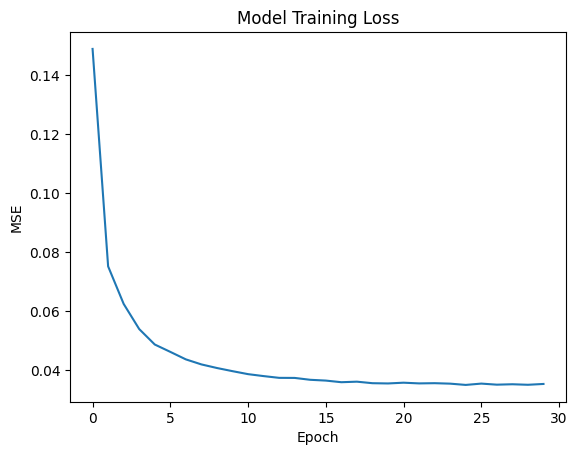

In [35]:
# function to train the model
def train_model(model, replay, epochs=30, batch_size=256):
    # Note: i used a batch_size so i dont update the Neural Network every time, i did this to speed up training like we did with QNN
    mse_loss = nn.MSELoss()
    model.to('cpu')
    best_state = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    losses = []# Average Loss per Epoch

    n_batches = max(1, replay.size // batch_size)
    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        for _ in range(n_batches):
            # Get state, actions, state differance (delta)
            batch = replay.sample(batch_size)
            s = batch["s"]
            a = batch["a"]
            delta = batch["delta"]

            # normalize
            inp = inp_norm.normalize(np.concatenate([s, a], axis=1))
            targ = targ_norm.normalize(delta)
            inp_t = th.as_tensor(inp, dtype=th.float32, device='cpu') # make them tensors
            targ_t = th.as_tensor(targ, dtype=th.float32, device='cpu')

            pred = model(inp_t) # predict delta s
            loss = mse_loss(pred, targ_t) # compute mean squared error
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        epoch_loss /= n_batches
        losses.append(epoch_loss)
        scheduler.step()

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {ep+1}/{epochs} loss={epoch_loss:.6f} lr={scheduler.get_last_lr()[0]:.2e}") # print training information for each epoch
    model.load_state_dict(best_state)
    return losses


# Collect Some Random Data
collect_random(env, replay, steps=100000, seed=42)
print("Collected:", replay.size, "transitions")

# Update the Normilizers with whats in the replay buffer
update_normalizers_from_buffer(replay)
print("Normalizers ready. obs count:", obs_norm.count) # moved this from above to here

# Actually Train the Model (and plot the loss)
print("Training model...")
losses = train_model(model, replay, epochs=30, batch_size=256)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Model Training Loss")
plt.show()

## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-step MSE: 0.6623585672893608


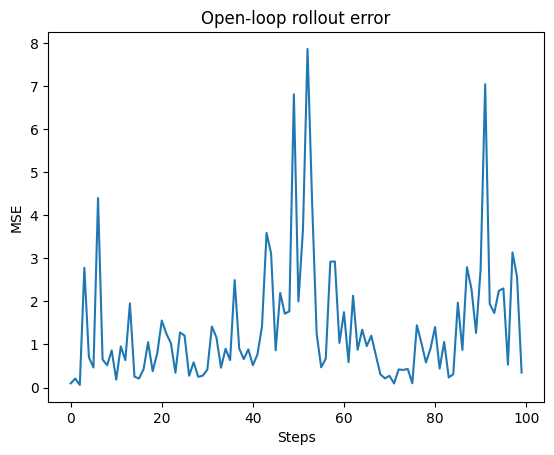

In [39]:
def one_step_mse(model, replay, batch_size=500):
    model.eval()
    batch = replay.sample(min(batch_size, replay.size))

    s = batch["s"]
    a = batch["a"]
    delta = batch["delta"]

    # normalize inputs
    inp = inp_norm.normalize(np.concatenate([s, a], axis=1))
    inp_t = th.as_tensor(inp, dtype=th.float32)

    # predict
    with th.no_grad():
        pred_norm = model(inp_t).numpy()

    # un-normalize prediction
    pred_delta = targ_norm.denormalize(pred_norm)

    # mean squared error (un-normalized)
    mse = np.mean((pred_delta - delta) ** 2)
    return mse

def multi_step_error(env, model, k=50):
    model.eval()
    s, _ = env.reset()
    s_model = s.copy()

    errors = []

    for t in range(k):
        a = env.action_space.sample()

        # real env
        sp, _, done, trunc, _ = env.step(a)

        # model prediction
        inp = inp_norm.normalize(np.concatenate([s_model[None], a[None]], axis=1))
        with th.no_grad():
            pred_norm = model(th.as_tensor(inp, dtype=th.float32)).numpy()
        pred_delta = targ_norm.denormalize(pred_norm)[0]
        s_model = s_model + pred_delta

        errors.append(np.mean((s_model - sp) ** 2))

        if done or trunc:
            break

        s = sp

    return np.array(errors)





# Results
mse = one_step_mse(model, replay)
print("One-step MSE:", mse)

err = multi_step_error(env, model, k=100)
plt.plot(err)
plt.xlabel("Steps")
plt.ylabel("MSE")
plt.title("Open-loop rollout error")
plt.show()


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



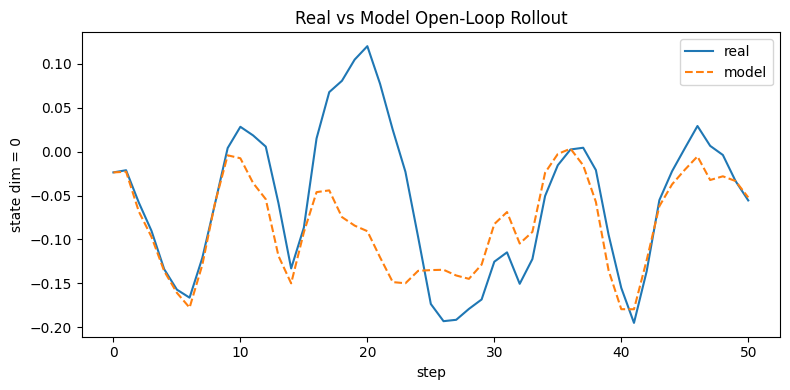

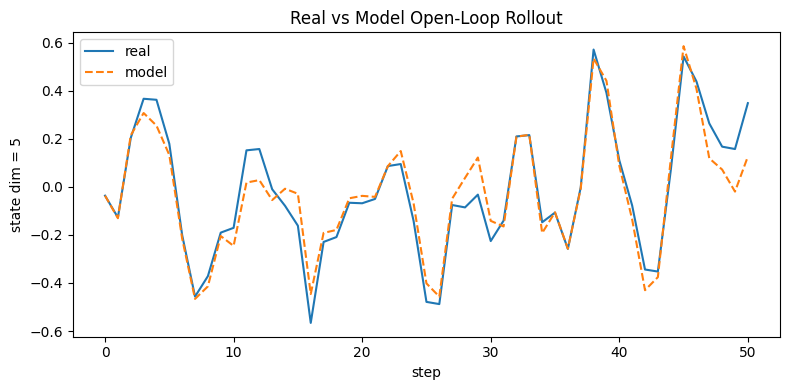

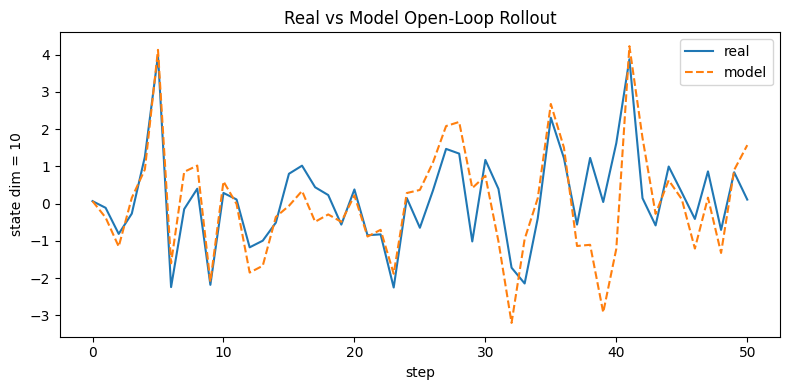

In [44]:
def visualize_rollout(env, model, k=50, dim=0, seed=2025):
    """Plot real vs model rollout for one observation dimension."""
    model.eval()
    s, _ = env.reset(seed=seed)
    s_model = s.copy()

    real_vals = [s[dim]]
    model_vals = [s_model[dim]]

    # Pre-sample actions
    actions = [env.action_space.sample() for _ in range(k)]

    for a in actions:
        sp, r, term, trunc, info = env.step(a)
        real_vals.append(sp[dim])

        inp = inp_norm.normalize(np.concatenate([s_model[None, :], a[None, :]], axis=1))
        with th.no_grad():
            pred_norm = model(th.as_tensor(inp, dtype=th.float32)).cpu().numpy()
        pred_delta = targ_norm.denormalize(pred_norm)[0]
        s_model = s_model + pred_delta
        model_vals.append(s_model[dim])

        if term or trunc:
            break

    steps = len(real_vals)
    plt.figure(figsize=(8,4))
    plt.plot(range(steps), real_vals, label="real")
    plt.plot(range(steps), model_vals, '--', label="model")
    plt.xlabel("step")
    plt.ylabel(f"state dim = {dim}")
    plt.title("Real vs Model Open-Loop Rollout")
    plt.legend()
    plt.tight_layout()
    plt.show()

# results (note, i made 3 seperate graphs for the requested dimmensions)
visualize_rollout(env, model, k=50, dim=0)
visualize_rollout(env, model, k=50, dim=5)
visualize_rollout(env, model, k=50, dim=10)

**How good is your model?**    
The model seems to be pretty good.  the MSE is ~0.66 meaning the model is capable of predicting the next state well.  But during the open-loop-rollbacks evalulation we can see that errors can accumulate quickly becuase the model uses its possibly mistaken predictions as inputs.  Therefore the model is good in the short term but in the long term may be unreliable


**Is this training enough for planning, or do we need continual training?**    
It is probably NOT good enough for planning. for MPPI the model needs to stay accurate for many steps ahead.  Our model shows errors that compound which would not be good for longer horizons



**How is this system different from the mountain car problem? Why can't we learn this in one episode?**     
This Problem is in 3D and has a 6 dimention continuous action space VS in the mountain car problem it was 2D with a small action space.  Also rollouts in this problem most likely do not cover much of the action space as it is continous vs the mountain car problem a rollout may cover most of the action space which is why we were able to learn it in one epsisode and is why we cant learn this problem in one episode.


**Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.**  

Becuase the distribution of the data changes as the replay buffer fills up.  This allows the normilizer to reflect the current data in the replay buffer and not older data